# Importing data from a sample csv


In [1]:
# not sure why the instructor suggests using this csv method, when pandas can import an xls file directly
import csv

# This is just to show that I am able to read a csv file
with open("sample-data.csv", "r") as file:
    reader = csv.reader(file, delimiter=",")
    for row in reader:
        print(row)

['first_name', 'last_name', 'email', 'phone']
['John', 'Doe', 'john@gmail.com', '1234567890']
['Kelly', 'Smith', 'ks@gmail.com', '3444583989']
['Roger', 'Moore', 'moore@gmail.com', '8876567890']
['Edward', 'Smith', 'esmith@gmail.com', '2222223332']
['Lenny', 'Warren', 'coollenny@yahoo.com', '3333333333']
['Trish', 'Lopez', 'lolo@gmail.com', '3432223833']


# Create DDL to create the database and tables


In [1]:
# connect to mysql
# first install the mysql-connector-python package using the following command
#   pip install mysql-connector-python

import mysql.connector
import yaml

db = yaml.safe_load(open("secrets.yaml"))

# Establish a connection to the MySQL server
cnx = mysql.connector.connect(
    host=db["DB_HOST"],
    user=db["DB_USER"],  # both root and andrewcbuensalida works
    password=db["DB_PASSWORD"],
)


# Create a cursor object
cursor = cnx.cursor()

# Use the created database
cursor.execute("USE mrts")

In [62]:
# Skip this and all the other inserts if the database already exists

# Drop the database if it exists
cursor.execute("DROP DATABASE IF EXISTS mrts")

# Create a database
cursor.execute("CREATE DATABASE mrts")

# Use the created database
cursor.execute("USE mrts")

# Create the NAICS code table
cursor.execute(
    """
    CREATE TABLE naics_code (
        id INT AUTO_INCREMENT PRIMARY KEY,
        naics_code VARCHAR(255)
    )
"""
)

# Create the kind of business table
cursor.execute(
    """
    CREATE TABLE kind_of_business (
        id INT AUTO_INCREMENT PRIMARY KEY,
        kind_of_business VARCHAR(255)
    )
"""
)

# Create the sales table
cursor.execute(
    """
    CREATE TABLE sales (
        id INT AUTO_INCREMENT PRIMARY KEY,
        sales_amount DECIMAL(10, 2),
        month INT,
        year INT,
        kind_of_business_id INT,
        FOREIGN KEY (kind_of_business_id) REFERENCES kind_of_business(id)
    )
"""
)

# Create the NAICS code-kind of business association table
cursor.execute(
    """
    CREATE TABLE naics_kind_of_business_association (
        naics_code_id INT,
        kind_of_business_id INT,
        FOREIGN KEY (naics_code_id) REFERENCES naics_code(id),
        FOREIGN KEY (kind_of_business_id) REFERENCES kind_of_business(id)
    )
"""
)

# Importing data from mrts csv year 2020 then save into mysql


In [63]:
# Insert kind of business into sql table
for i in range(1992, 2021):
    with open(f"mrtssales92-present/{i}.csv", "r") as file:
        reader = csv.reader(file, delimiter=",")
        for index, row in enumerate(reader):
            if index >= 6 and index <= 70:  # not adjusted industry categories
                # Check if the kind of business already exists
                query = (
                    "SELECT COUNT(*) FROM kind_of_business WHERE kind_of_business = %s"
                )
                data = (row[1],)

                # Execute the query
                cursor.execute(query, data)

                # Fetch the result
                result = cursor.fetchone()

                # Extract the count from the result
                count = result[0]

                # If the kind of business doesn't exist, insert it into the table
                if count == 0:
                    # Insert kind of business in table
                    query = (
                        "INSERT INTO kind_of_business (kind_of_business) VALUES (%s)"
                    )
                    data = (row[1],)

                    # Execute the query
                    cursor.execute(query, data)

                    # Commit the transaction
                    cnx.commit()

In [64]:
# Insert NAICS codes into table
for i in range(1992, 2021):
    with open(f"mrtssales92-present/{i}.csv", "r") as file:
        reader = csv.reader(file, delimiter=",")
        for index, row in enumerate(reader):
            if index >= 6 and index <= 70 and row[0]:  # not adjusted industry categories
                codes = row[0].split(",")

                for code in codes:
                    # Check if the code already exists in the table
                    query = "SELECT COUNT(*) FROM naics_code WHERE naics_code = %s"
                    data = (code,)

                    # Execute the query
                    cursor.execute(query, data)

                    # Fetch the result
                    result = cursor.fetchone()

                    # Extract the count from the result
                    count = result[0]

                    # If the code doesn't exist, insert it into the table
                    if count == 0:
                        query = "INSERT INTO naics_code (naics_code) VALUES (%s)"
                        data = (code,)

                        # Execute the query
                        cursor.execute(query, data)

                        # Commit the transaction
                        cnx.commit()

In [65]:
# Insert NAICS code-kind of business associations into table
for i in range(1992, 2021):
    with open(f"mrtssales92-present/{i}.csv", "r") as file:
        reader = csv.reader(file, delimiter=",")
        for index, row in enumerate(reader):
            if index >= 6 and index <= 70 and row[0]:  # not adjusted industry categories
                codes = row[0].split(",")

                for code in codes:
                    # Get the NAICS code ID
                    query = "SELECT id FROM naics_code WHERE naics_code = %s"
                    data = (code,)

                    # Execute the query
                    cursor.execute(query, data)

                    # Fetch the result
                    result = cursor.fetchone()

                    # Extract the ID from the result
                    naics_code_id = result[0]

                    # Get the kind of business ID
                    query = "SELECT id FROM kind_of_business WHERE kind_of_business = %s"
                    data = (row[1],)

                    # Execute the query
                    cursor.execute(query, data)

                    # Fetch the result
                    result = cursor.fetchone()

                    # Extract the ID from the result
                    kind_of_business_id = result[0]

                    # Insert the association into the table
                    query = "INSERT INTO naics_kind_of_business_association (naics_code_id, kind_of_business_id) VALUES (%s, %s)"
                    data = (naics_code_id, kind_of_business_id)

                    # Execute the query
                    cursor.execute(query, data)

                    # Commit the transaction
                    cnx.commit()

In [15]:
# Insert sales data into table. This takes about 1.5 minutes to run.
for i in range(1992, 2021):
    with open(f"mrtssales92-present/{i}.csv", "r") as file:
        reader = csv.reader(file, delimiter=",")
        for index, row in enumerate(reader):
            if index == 0:
                title = row[0]

            if index >= 6 and index <= 70:  # not adjusted industry categories. This might break if they add or remove kind of businesses.
                #  Get the kind of business id from sql
                query = "SELECT id FROM kind_of_business WHERE kind_of_business = %s"
                data = (row[1],)

                # Execute the query
                cursor.execute(query, data)

                # Fetch the result
                result = cursor.fetchone()

                # Extract the id from the result
                if result:
                    kind_of_business_id = result[0]
                else:
                    print(
                        "No matching id found"
                    )  # maybe could add a new kind of business here

                # sales from january to december
                # sales = row[2:-1] # This is brittle because in 2016 there is an extra empty column after total sales
                sales = row[2:14]

                for index, sales_amount in enumerate(sales):
                    month = index + 1
                    year = int(title.split(":")[-1])
                    if (
                        sales_amount != "(S)" and sales_amount != "(NA)" and sales_amount
                    ):  # There are some data that have a string (S) instead of a proper sales amount, and some are empty. Just don't insert these sales. Might have to make this more generalized.

                        sales_amount_float = float(sales_amount.replace(",", ""))

                        data = [kind_of_business_id, sales_amount_float, month, year]
                        print(data)

                        # The SQL query to insert the data
                        query = "INSERT INTO sales (kind_of_business_id, sales_amount, month, year) VALUES (%s, %s, %s, %s)"

                        # Execute the query
                        cursor.execute(query, data)

                        # Commit the transaction
                        cnx.commit()

[1, 401911.0, 1, 2016]
[1, 415093.0, 2, 2016]
[1, 460910.0, 3, 2016]
[1, 451121.0, 4, 2016]
[1, 470116.0, 5, 2016]
[1, 464721.0, 6, 2016]
[1, 462004.0, 7, 2016]
[1, 471690.0, 8, 2016]
[1, 448516.0, 9, 2016]
[1, 453155.0, 10, 2016]
[1, 467232.0, 11, 2016]
[1, 539667.0, 12, 2016]
[2, 321013.0, 1, 2016]
[2, 324880.0, 2, 2016]
[2, 359702.0, 3, 2016]
[2, 353383.0, 4, 2016]
[2, 371156.0, 5, 2016]
[2, 366135.0, 6, 2016]
[2, 362111.0, 7, 2016]
[2, 367377.0, 8, 2016]
[2, 352800.0, 9, 2016]
[2, 360140.0, 10, 2016]
[2, 376891.0, 11, 2016]
[2, 438631.0, 12, 2016]
[3, 370863.0, 1, 2016]
[3, 386106.0, 2, 2016]
[3, 427324.0, 3, 2016]
[3, 415844.0, 4, 2016]
[3, 431308.0, 5, 2016]
[3, 424659.0, 6, 2016]
[3, 422252.0, 7, 2016]
[3, 432935.0, 8, 2016]
[3, 410592.0, 9, 2016]
[3, 414177.0, 10, 2016]
[3, 431420.0, 11, 2016]
[3, 502513.0, 12, 2016]
[4, 289965.0, 1, 2016]
[4, 295893.0, 2, 2016]
[4, 326116.0, 3, 2016]
[4, 318106.0, 4, 2016]
[4, 332348.0, 5, 2016]
[4, 326073.0, 6, 2016]
[4, 322359.0, 7, 2016]
[4

# Explore trends


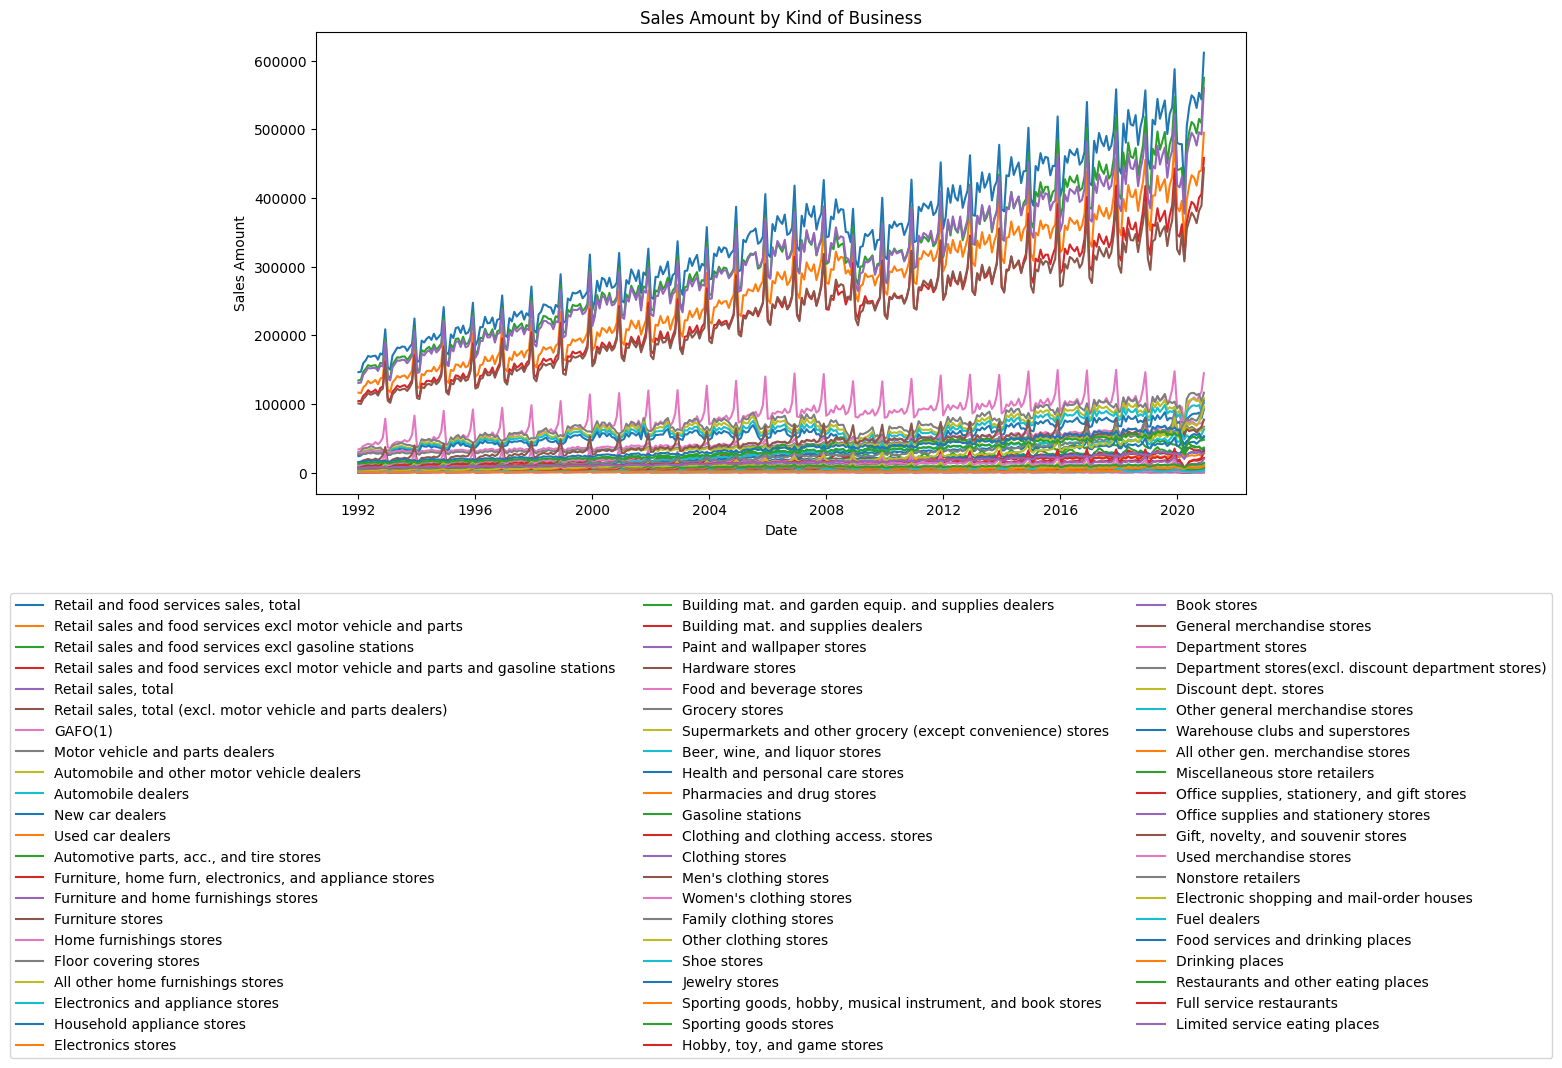

In [57]:
# plot sales trend of all kinds of businesses from 1992 to 2020
import matplotlib.pyplot as plt
import pandas as pd

# Execute the SQL query to select all rows from the "sales" table
query = """SELECT sales_amount, month, year, kind_of_business FROM sales
JOIN kind_of_business
ON sales.kind_of_business_id = kind_of_business.id;"""
cursor.execute(query)

# Fetch all the rows from the result
rows = cursor.fetchall()

# Create a pandas DataFrame from the fetched rows
df = pd.DataFrame(rows, columns=["sales_amount", "month", "year", "kind_of_business"])

# Convert "month" and "year" columns to datetime format
df["date"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str), format="%Y-%m")

# Set the "date" column as the index
df.set_index("date", inplace=True)

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the line chart
for kind_of_business in df["kind_of_business"].unique():
    data = df[df["kind_of_business"] == kind_of_business].sort_index()
    plt.plot(data.index, data["sales_amount"], label=kind_of_business)

# Set the x-axis label
plt.xlabel("Date")

# Set the y-axis label
plt.ylabel("Sales Amount")

# Set the title of the chart
plt.title("Sales Amount by Kind of Business")

# Move the legend to the bottom
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=3)

# Show the chart
plt.show()

In [ ]:
# Compare 3 business kinds. Plot the trend of sales_amount where the kind_of_business is Book stores, Sporting goods stores, Electronics stores.
# What has the highest trend?
# Which one grew faster?
# Which one is higher?
# Is there a seasonality?
# Are there any changes in 2020?
# Which is better, monthly or yearly?

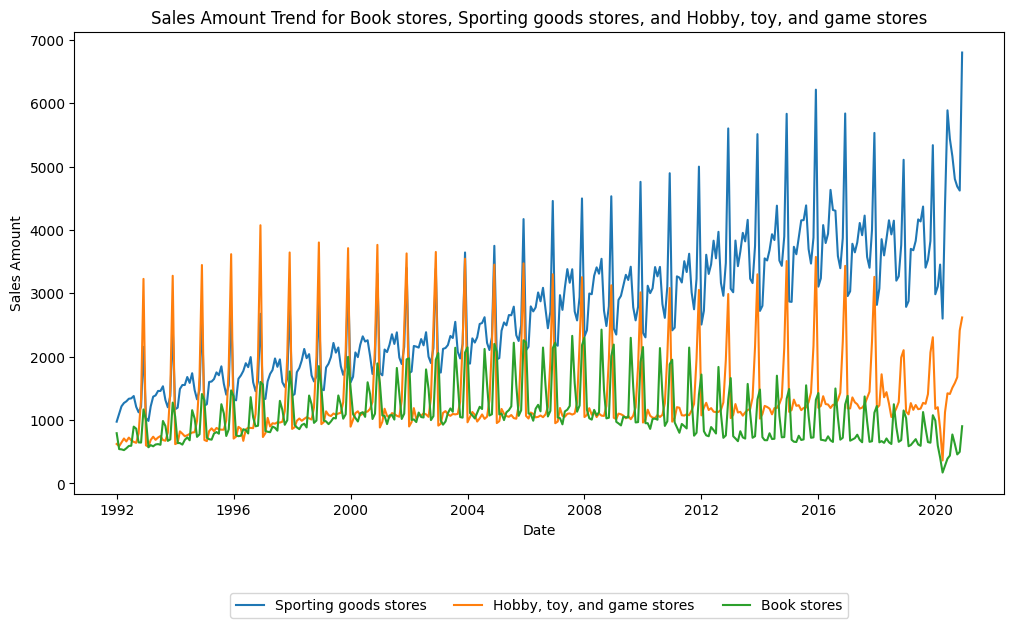

In [91]:
import numpy as np
# Filter the DataFrame for the desired kind_of_business values
kind_to_include = [
    "Sporting goods stores",
    "Hobby, toy, and game stores",
    "Book stores",
]
kind_filter = df["kind_of_business"].isin(kind_to_include)
df_filtered = df[kind_filter].sort_index()

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the line chart.
for kind_of_business in kind_to_include:
    data = df_filtered[df_filtered['kind_of_business'] == kind_of_business]
    plt.plot(data.index, data['sales_amount'], label=kind_of_business)

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales Amount')

# Set the title of the chart
plt.title(
    "Sales Amount Trend for Book stores, Sporting goods stores, and Hobby, toy, and game stores"
)

# Move the legend to the bottom
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)

# Show the chart
plt.show()

<Axes: title={'center': 'Stacked Bar Graph'}, xlabel='month'>

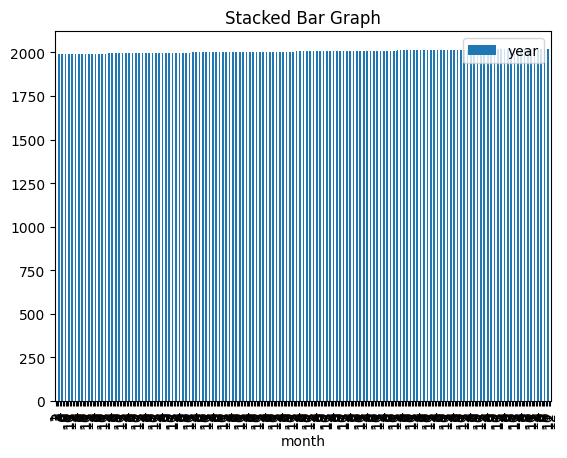

In [98]:
df_filtered[df_filtered["kind_of_business"] == "Sporting goods stores"].plot(
    x="month", kind="bar", stacked=True, title="Stacked Bar Graph", mark_right=True
)

month
1     2078.103448
2     2116.275862
3     2659.551724
4     2581.206897
5     2752.931034
6     3023.172414
7     2900.827586
8     3074.448276
9     2547.827586
10    2409.482759
11         2698.0
12    4245.793103
Name: sales_amount, dtype: object
a
month
1      943.758621
2           976.0
3     1119.896552
4     1040.275862
5      1044.37931
6     1046.655172
7     1061.241379
8     1058.827586
9     1084.517241
10    1244.965517
11    2045.068966
12    3317.275862
Name: sales_amount, dtype: object
a
month
1     1614.275862
2       849.37931
3      822.172414
4      782.137931
5      889.965517
6       882.62069
7      861.965517
8     1638.586207
9     1211.862069
10          848.0
11     888.172414
12         1625.0
Name: sales_amount, dtype: object
a


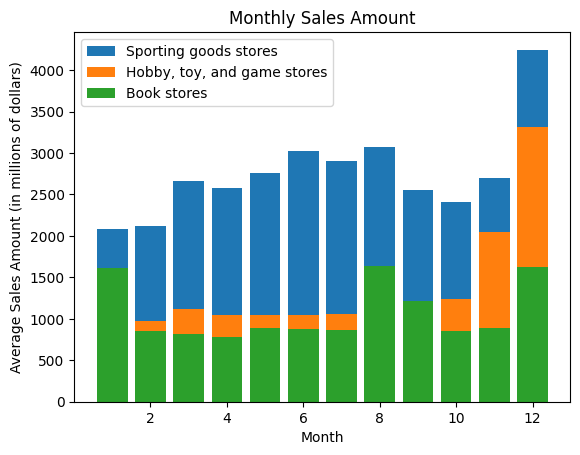

In [109]:
# Trend by month
# Group sales_amount by kind
for kind_of_business in kind_to_include:
    data = df_filtered[df_filtered["kind_of_business"] == kind_of_business]
    # print(data)
    monthly_sales_avg = data.groupby("month")["sales_amount"].mean()
    print(monthly_sales_avg)
    print('a')
    
    plt.bar(monthly_sales_avg.index, monthly_sales_avg.values, label=kind_of_business)


# Set the labels and title
plt.xlabel('Month')
plt.ylabel('Average Sales Amount (in millions of dollars)')
plt.title('Monthly Sales Amount')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Explore percentage change


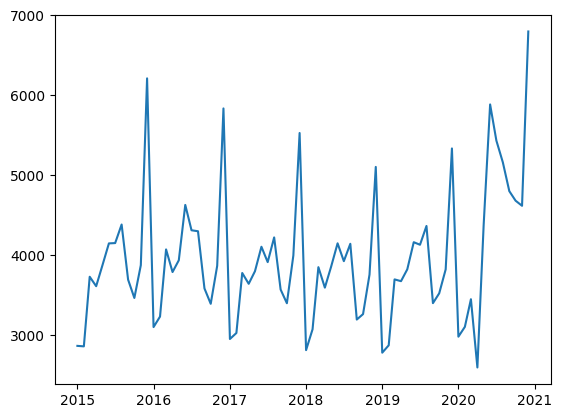

# Explore rolling time windows


In [67]:
# # Close the cursor and connection
cursor.close()
cnx.close()